In [1]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
import missingno as msno

import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
# Directory where mp3 are stored.
AUDIO_DIR = 'data/fma_small'

# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [3]:
tracks.head()

album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2  4   

                                                                           \
                                        information listens producer tags   
track_id                                                                    
2                                           <p></p>    6073      NaN   []   
3                                           <p></p>    6073      NaN   []   
5                                           <p></p>    6073      NaN   []   
10                                              NaN   47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>    2710      NaN   []   

          ...       track                         \
          ... information interest language_code   
track_id  ...                                      
2         ...         NaN     4656            en   
3         ...         NaN     1470            en   
5         ...         NaN     1933            en   
10        ...         NaN    54881            en   
20        ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

First of all we want to flatten the column hierarchy of our tables, by just joining the top column name with it's respective subordinate columns in the format: "top-column_name_subordinate_column_name"

In [4]:
tracks.columns = tracks.columns.map('_'.join)
tracks = tracks.reset_index()

In [5]:
tracks.columns

Index(['track_id', 'album_comments', 'album_date_created',
       'album_date_released', 'album_engineer', 'album_favorites', 'album_id',
       'album_information', 'album_listens', 'album_producer', 'album_tags',
       'album_title', 'album_tracks', 'album_type', 'artist_active_year_begin',
       'artist_active_year_end', 'artist_associated_labels', 'artist_bio',
       'artist_comments', 'artist_date_created', 'artist_favorites',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_members', 'artist_name', 'artist_related_projects',
       'artist_tags', 'artist_website', 'artist_wikipedia_page', 'set_split',
       'set_subset', 'track_bit_rate', 'track_comments', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_duration',
       'track_favorites', 'track_genre_top', 'track_genres',
       'track_genres_all', 'track_information', 'track_interest',
       'track_language_code', 'track_license', 'track_listens',
  

In [6]:
#filter tracks.csv for subset==small 
tracks_small = tracks[tracks['set_subset'] == 'small']

In [7]:
tracks_small.head(10)

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
2,5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
15,140,1,2008-11-26 01:49:59,2007-05-22,NaN,1,61,<p>Alec K. Redfearn &amp; The Eyesores: Ellen ...,1300,"Alec K. Refearn, Rob Pemberton",...,NaN,1593,en,Attribution-Noncommercial-No Derivative Works ...,1299,NaN,2,NaN,[],Queen Of The Wires
16,141,0,2008-11-26 01:49:57,2009-01-16,NaN,1,60,"<p>A full ensamble of strings, drums, electron...",1304,NaN,...,NaN,839,en,Attribution-Noncommercial-No Derivative Works ...,725,NaN,4,NaN,[],Ohio
22,148,0,2008-11-26 01:50:19,2009-01-15,NaN,0,66,"<p>""Compositions for electronics and voice."" I...",1831,NaN,...,NaN,2437,en,Attribution-Noncommercial-Share Alike 3.0 Unit...,1831,NaN,2,NaN,[],Blackout 2
55,182,0,2008-11-26 01:52:18,2005-04-26,NaN,0,80,<p><em>Worn Copy</em> is the history of pop...,5289,NaN,...,NaN,5990,en,Attribution-Noncommercial-No Derivative Works ...,5547,NaN,3,NaN,[],Jules Lost His Jewels
61,190,0,2008-11-26 01:52:31,2009-01-07,NaN,0,84,<p><em>Blue Piano</em> is an unreleased collec...,12333,NaN,...,NaN,1758,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,945,NaN,2,NaN,[],Castle Of Stars
64,193,0,2008-11-26 01:52:31,2009-01-07,NaN,0,84,<p><em>Blue Piano</em> is an unreleased collec...,12333,NaN,...,NaN,1679,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,824,NaN,3,NaN,[],Here With You
65,194,0,2008-11-26 01:52:31,2009-01-07,NaN,0,84,<p><em>Blue Piano</em> is an unreleased collec...,12333,NaN,...,NaN,1780,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,754,NaN,4,NaN,[],All I want to Do


In [8]:
tracks_small.to_csv('data/fma_metadata/tracks_small.csv')

In [9]:
features.columns = features.columns.map('_'.join)
features = features.reset_index()

In [10]:
features

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,-0.490129,0.463834,2.321970,-0.084352,1.662914,2.115189,-0.237794,5.695442,0.830353,...,0.128410,0.022547,0.019816,4.448255,0.172852,0.028773,0.028320,0.003906,0.955388,0.012385
106570,155317,-0.461559,-0.229601,-0.496632,-0.422033,0.130612,-0.263825,-0.628103,-0.082687,-0.229483,...,0.132964,0.023548,0.026527,3.270612,0.196289,0.031116,0.027832,0.002441,1.283060,0.019059
106571,155318,0.552473,-0.110498,-0.532014,0.263131,-0.224011,-0.530972,1.713526,1.418444,1.325197,...,0.108324,0.017540,0.020471,2.356727,0.212891,0.038450,0.037109,0.003418,0.828569,0.017904
106572,155319,-0.176901,0.187208,-0.050664,0.368843,0.066005,-0.857354,-0.780860,0.626281,-0.630938,...,0.088311,0.018328,0.017936,6.188604,0.167480,0.041480,0.038086,0.004883,1.818740,0.020133


In [11]:
df_merged = tracks_small.merge(features, on='track_id', how='left')

In [12]:
df_merged

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
2,10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
3,140,1,2008-11-26 01:49:59,2007-05-22,NaN,1,61,<p>Alec K. Redfearn &amp; The Eyesores: Ellen ...,1300,"Alec K. Refearn, Rob Pemberton",...,0.157683,0.028070,0.025946,11.052547,0.379395,0.052379,0.036621,0.001953,3.143968,0.057712
4,141,0,2008-11-26 01:49:57,2009-01-16,NaN,1,60,"<p>A full ensamble of strings, drums, electron...",1304,NaN,...,0.145994,0.024342,0.032111,32.994659,0.415527,0.040267,0.034668,0.002930,4.204097,0.028665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,154308,0,2017-03-05 04:57:38,2017-03-05,NaN,0,22780,NaN,22334,Fleslit,...,0.117287,0.021906,0.021999,53.807804,0.769043,0.042997,0.022949,0.001953,6.928385,0.084298
7996,154309,0,2017-03-05 04:57:38,2017-03-05,NaN,0,22780,NaN,22334,Fleslit,...,0.180397,0.029303,0.023771,12.597441,0.768555,0.082979,0.037109,0.008789,3.441251,0.129480
7997,154413,0,2017-03-07 18:44:11,NaT,Ernie Indradat,0,22789,<p>A live performance at WFMU for Dark Night o...,3777,Julie Bennack,...,0.156587,0.036926,0.038113,25.368595,0.323242,0.024532,0.018066,0.000977,3.736646,0.023821
7998,154414,0,2017-03-07 18:44:11,NaT,Ernie Indradat,0,22789,<p>A live performance at WFMU for Dark Night o...,3777,Julie Bennack,...,0.181294,0.026723,0.030980,21.276468,0.511230,0.046116,0.033691,0.003418,3.997052,0.045733


Now we can investigate the missing values in our dataset.

<Axes: >

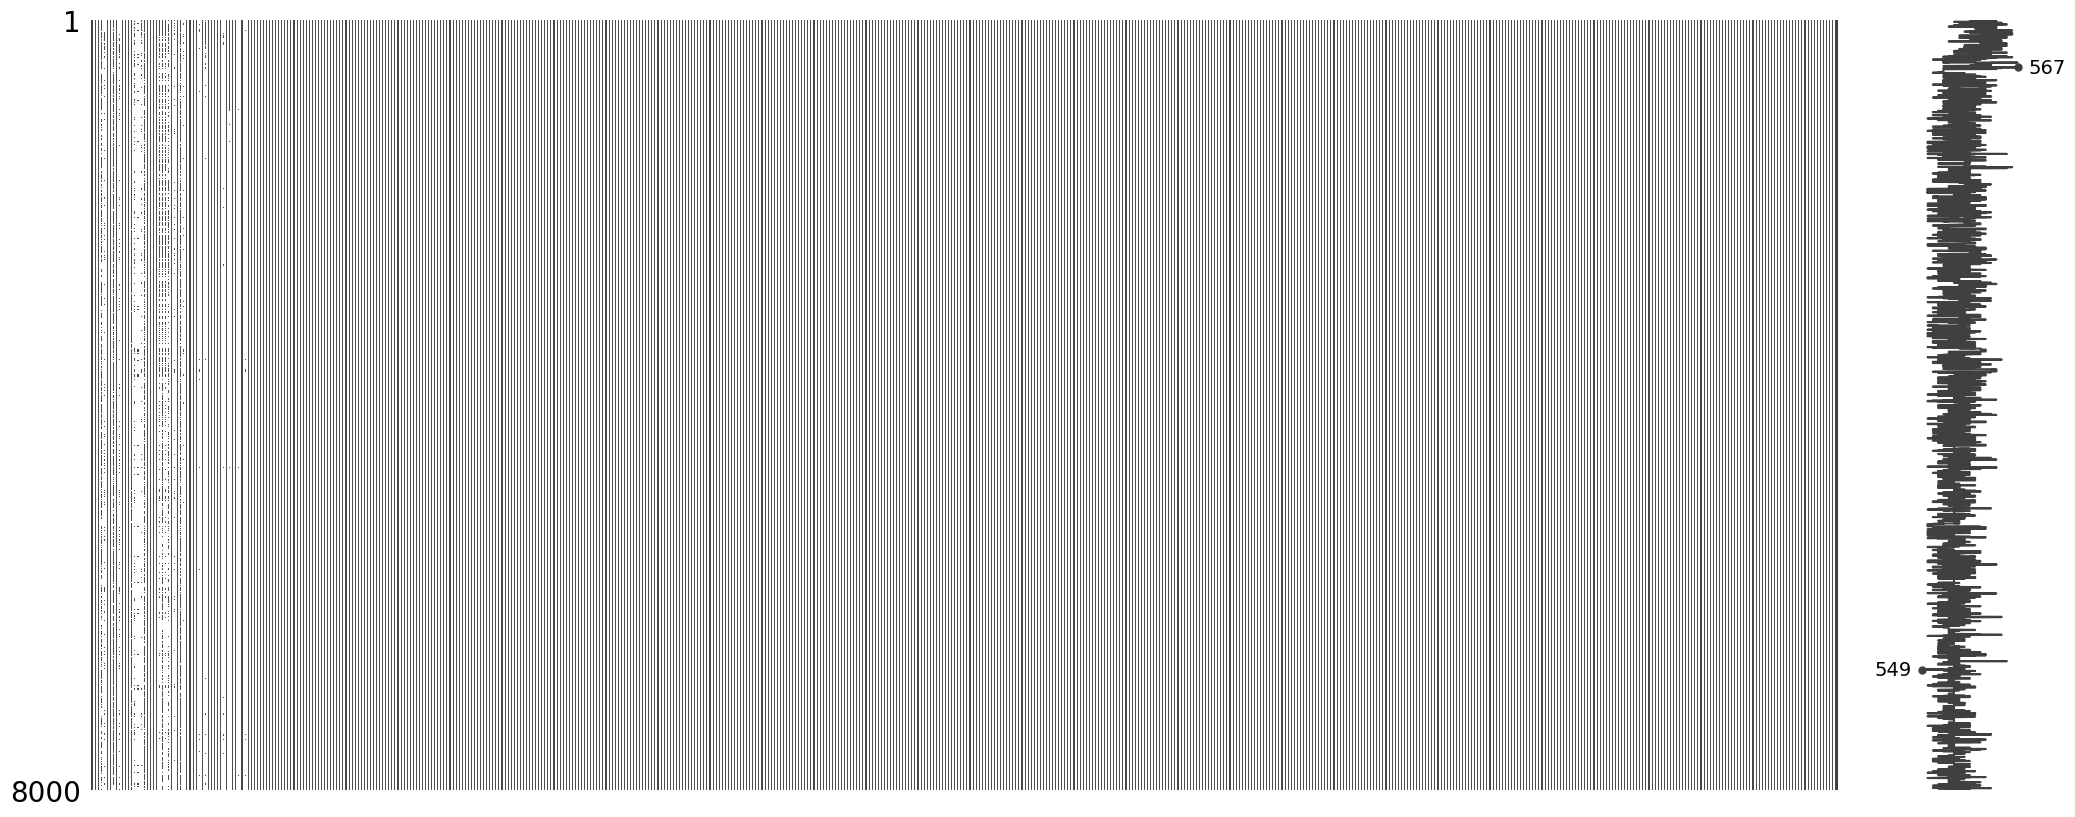

In [13]:
msno.matrix(df_merged)

In [14]:
df_merged.isna().sum()

track_id                  0
album_comments            0
album_date_created        0
album_date_released    2663
album_engineer         6858
                       ... 
zcr_mean_01               0
zcr_median_01             0
zcr_min_01                0
zcr_skew_01               0
zcr_std_01                0
Length: 571, dtype: int64

In [15]:
print(f"numbers of rows : {df_merged.shape[0]}")
for index, col in enumerate(df_merged.columns):
    if df_merged[col].isna().sum() != 0:
        print(f"missing values in {index} - {col} : {round(df_merged[col].isna().sum()/df_merged.shape[0]*100,2)} %")

print(f"missing values in data frame : {round(df_merged.isna().sum().sum()/(df_merged.shape[0]*df_merged.shape[1])*100,2)} %")

numbers of rows : 8000
missing values in 3 - album_date_released : 33.29 %
missing values in 4 - album_engineer : 85.72 %
missing values in 7 - album_information : 18.73 %
missing values in 9 - album_producer : 82.45 %
missing values in 13 - album_type : 2.89 %
missing values in 14 - artist_active_year_begin : 80.73 %
missing values in 15 - artist_active_year_end : 95.52 %
missing values in 16 - artist_associated_labels : 89.39 %
missing values in 17 - artist_bio : 26.08 %
missing values in 22 - artist_latitude : 63.76 %
missing values in 23 - artist_location : 31.61 %
missing values in 24 - artist_longitude : 63.76 %
missing values in 25 - artist_members : 55.94 %
missing values in 27 - artist_related_projects : 91.32 %
missing values in 29 - artist_website : 19.35 %
missing values in 30 - artist_wikipedia_page : 94.88 %
missing values in 35 - track_composer : 97.75 %
missing values in 37 - track_date_recorded : 94.19 %
missing values in 43 - track_information : 98.01 %
missing values

Based on the upper overview we decided the following:
 - Drop all columns with missing values > 80%
 - Impute 'album_type' and 'track_license' with their respective mode value
 - One-Hot-Encode the columns: 'album_information', 'artist_bio', 'artist_website'
 - Drop all remaining columns as well, since imputing them would be too elaborate and difficult

In [16]:
#Impute with Mode
df_tracks_features = df_merged.copy()
df_tracks_features['track_license'].fillna(df_tracks_features['track_license'].mode()[0], inplace=True)

In [17]:
#Impute with Mode
df_tracks_features['album_type'].fillna(df_tracks_features['album_type'].mode()[0], inplace=True)

In [18]:
df_tracks_features['track_license'].isna().value_counts()
df_tracks_features['album_type'].isna().value_counts()

album_type
False    8000
Name: count, dtype: int64

In [19]:
#One-Hot-Encoding
#In this cell we will turn string features containing text into a binary variable. 
#We assume that rows with NaN simply haven't got the respective feature, like bio or information.
#The original columns are dropped together with all other incomplete columns

# album_information, artist_bio, artist_website
df_tracks_features['album_information_bin'] = df_tracks_features['album_information'].notnull().astype(int)
df_tracks_features['artist_bio_bin'] = df_tracks_features['artist_bio'].notnull().astype(int)
df_tracks_features['artist_website_bin'] = df_tracks_features['artist_website'].notnull().astype(int)

In [20]:
# Drop all columns with missing values > 80% or which are simply not interesting or difficult to impute
df_tracks_features.drop(['artist_location', 'album_date_released', 'album_engineer', 'album_producer', 'artist_active_year_begin', 
                         'artist_active_year_end', 'artist_associated_labels', 'artist_latitude', 'artist_longitude', 
                         'artist_members', 'artist_related_projects', 'artist_wikipedia_page', 'track_composer', 'track_date_recorded', 
                         'track_information', 'track_language_code', 'track_lyricist', 'track_publisher', 'album_tags', 'track_tags', 'album_information', 
                         'artist_bio', 'artist_website'], axis=1, inplace=True)

In [21]:
df_tracks_features['track_id'].duplicated().value_counts()

track_id
False    8000
Name: count, dtype: int64

In [22]:
df_tracks_features.isna().sum()

track_id                 0
album_comments           0
album_date_created       0
album_favorites          0
album_id                 0
                        ..
zcr_skew_01              0
zcr_std_01               0
album_information_bin    0
artist_bio_bin           0
artist_website_bin       0
Length: 551, dtype: int64

<Axes: >

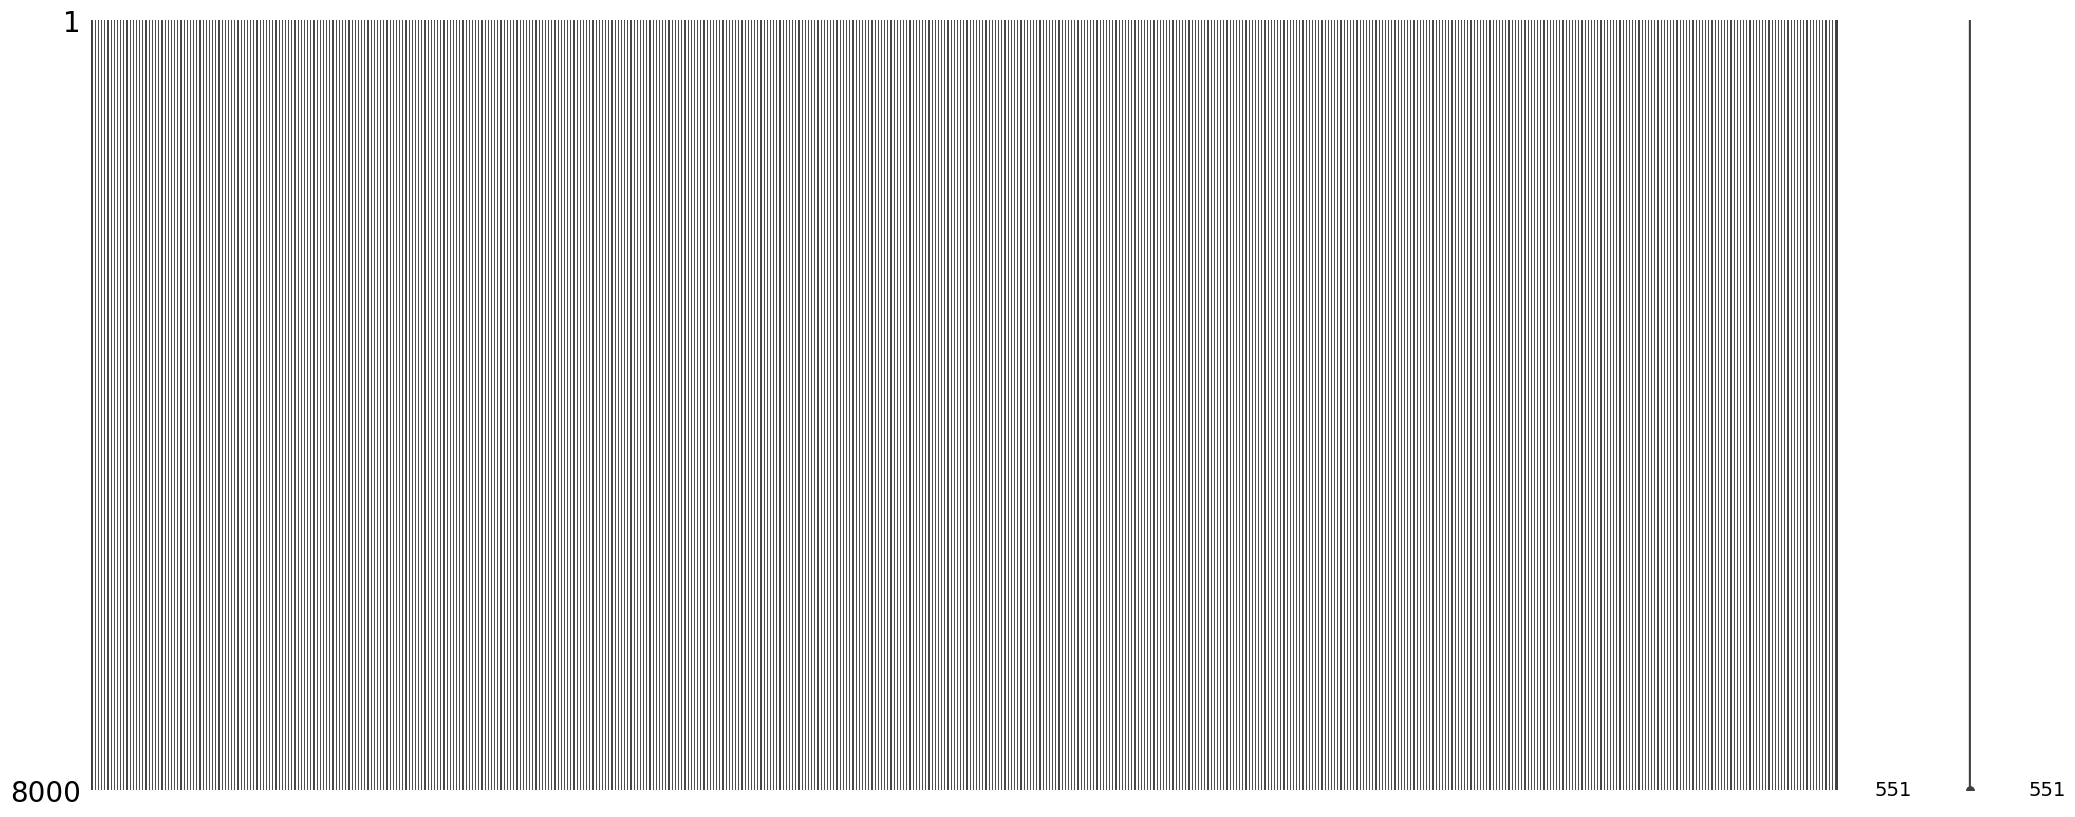

In [23]:
msno.matrix(df_tracks_features)

Save cleaned csv as file in data folder.

In [24]:
df_tracks_features.to_csv('data/data_cleaned.csv')